In [1]:
import pandas as pd
import numpy as np 
from sklearn.cluster import KMeans 
from sklearn.metrics import   silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

In [2]:
# Read data
beacons_data = pd.read_csv('../data/raw/beacons_dataset.csv', sep=';').drop(columns=['ts_date','ts_time'])
clinical_data = pd.read_csv('../data/preprocessed/clinical_data.csv', sep=';')

In [3]:
# Remove invalid part_id entries
for index, row in beacons_data.iterrows(): 
    if (not len(row['part_id']) == 4 or not row['part_id'].isdigit()):
       beacons_data.drop(index, inplace=True)  

# Aggregate similar labels to one
replacement_dict = { 
       'Kitchen': dict.fromkeys({'Kitcheb', 'Kithen', 'Kitchen2', 'Kitvhen', 'Kichen', 'Kiychen', 'Kitcen', 'Kitch', 'kitchen'}, 'Kitchen'),
       'Bedroom': dict.fromkeys({'Bedroom2', 'Bedroom1', 'bedroom', 'Bedroom-1', 'Bedroom1st', 'Chambre', 'Bed'}, 'Bedroom'), 
       'Outdoor': dict.fromkeys({'Veranda', 'Garden', 'Guard'}, 'Outdoor'),
       'Livingroom': dict.fromkeys({'TV', 'Livingroon', 'Livingroon', 'livingroom', 'LivingRoom2', 'Luvingroom1', 'SeatingRoom', 'LivibgRoom', 'Sitingroom', 'Livingroom1', 'Livingroom2', 'Leavingroom', 'Sittingroom', 'LivingRoom', 'Living', 'Livroom', 'Sittigroom', 'Liningroom', 'LeavingRoom', 'Sittinroom', 'SittingOver', 'SittingRoom'}, 'Livingroom'),
       'Bathroom': dict.fromkeys({'Barhroom', 'Baghroom', 'Bathroom-1', 'Bathroom1', 'Bathroon', 'Bathroim', 'Bsthroom'},'Bathroom'), 
       'Entry': dict.fromkeys({'Entrance', 'ExitHall', 'Hall'},'Entry'),
       'Office': dict.fromkeys({'Desk', 'Office1', 'Library', 'Workroom', 'Office2', 'Office-2', 'Office1st'},'Office'),
       'DiningRoom': dict.fromkeys({'DinningRoom', 'Dinerroom', 'DinerRoom','DinnerRoom' }, 'DiningRoom'),
       'nan': dict.fromkeys({'Right', 'Left', 'Two', 'Three', 'One', '2ndRoom', 'three', 'Four', 'Box', 'Box-1', 'K', 'T'},'nan'), 
       'Storage': dict.fromkeys({'Pantry', 'Garage'},'Storage'), 
       'Entry': dict.fromkeys({'Entrance', 'ExitHall', 'Hall'},'Entry')
}

for column in replacement_dict:
    beacons_data['room'].replace(replacement_dict[column], inplace=True)

# Extract Features from the preprocessed data
def divide(number1, number2):
    return round(float(number1 / number2), 2)

records = {}
bedroom = {}
bathroom = {}
livingroom = {}
kitchen = {}
person_dict = { 'part_id':[], 'Bedroom':[], 'Bathroom':[], 'Livingroom':[],'Kitchen':[]}
for value in beacons_data.part_id.unique():
    records[value] = len(beacons_data[(beacons_data.part_id == value)])
    bedroom[value] = len(beacons_data[(beacons_data.part_id == value) & (beacons_data.room == "Bedroom")]) 
    bathroom[value] = len(beacons_data[(beacons_data.part_id == value) & (beacons_data.room == "Bathroom")]) 
    livingroom[value] = len(beacons_data[(beacons_data.part_id == value) & (beacons_data.room == "Livingroom")]) 
    kitchen[value] = len(beacons_data[(beacons_data.part_id == value) & (beacons_data.room == "Kitchen")]) 
    person_dict['part_id'].append(int(value))
    person_dict['Bedroom'].append(divide(bedroom[value],records[value]))
    person_dict['Bathroom'].append(divide(bathroom[value],records[value]))
    person_dict['Livingroom'].append(divide(livingroom[value],records[value]))
    person_dict['Kitchen'].append(divide(kitchen[value],records[value]))

new_beacons_data = pd.DataFrame(person_dict)
new_beacons_data.to_csv('../data/preprocessed/beacons_data.csv', sep=';', index=False)

In [4]:
# merge beacons with clinical dataset
beacons_features = pd.read_csv('../data/preprocessed/beacons_data.csv', sep=';')
clinical_data = pd.read_csv('../data/preprocessed/clinical_data.csv', sep=';')
merged_data = pd.merge(beacons_features, clinical_data)
merged_data.to_csv('../data/preprocessed/merged_dataset.csv', sep=';', index=False)

In [5]:

data = pd.read_csv('../data/preprocessed/merged_dataset.csv', sep=';')
# Cluster data using K-means algorithm. 
results = { 'number_of_clusters': np.arange(2,8), 
      'silhouette_score': [], 
      'PCA_silhouette_score': []}
for i in range(2,8): 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
    labels = kmeans.labels_
    score = silhouette_score(data, labels)
    results['silhouette_score'].append(score)

# Reduce the dimantion of the data and then apply K-means again
for i in range(2,8):
    X = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    results['PCA_silhouette_score'].append(score)

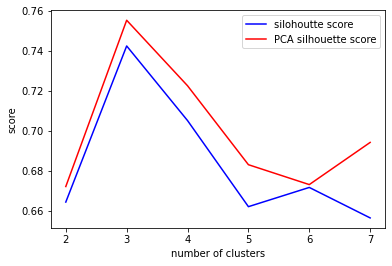

In [6]:
# Plot Silhouette value of the two approaches
plt.xlabel('number of clusters')
plt.ylabel('score')
 
plt.plot(results['number_of_clusters'], results['silhouette_score'],"-b", label='silohoutte score')
plt.plot(results['number_of_clusters'], results['PCA_silhouette_score'], "-r",label="PCA silhouette score")
plt.legend(loc="upper right")
plt.show()